# Main Notebook for Leakage Detection

## Setup

### Google Colab Setup

In [1]:
# Mount Google Colab files

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection


### Imports

In [2]:
!pip install wntr
!pip install scipy
%matplotlib inline

import wntr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from sklearn.metrics import confusion_matrix, recall_score, precision_score

In [28]:
import utils
import models
from utils.Network import WDN
from utils.Dataloader import Dataloader
from utils.Datagenerator import Datagenerator
from models.Classification import ClassificationModel

from utils.helper import any_transform

# Attention: Run twice for real reload effect
import importlib
importlib.reload(utils.Network)
importlib.reload(utils.Dataloader)
importlib.reload(utils.Datagenerator)
importlib.reload(models.Classification)

<module 'models.Classification' from '/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection/models/Classification.py'>

## Main

### Plotting

In [4]:
def plot(df, xlabel="Time (h)", ylabel="Pressure (m)", location="upper right", line_at=[], highlight_first=False):
  plt.figure()
  ax = df.plot()
  if highlight_first:
    plt.setp(ax.lines[0], linewidth=3)
  text = ax.set_xlabel(xlabel)
  text = ax.set_ylabel(ylabel)
  for line in line_at:
    plt.axvline(x=line, color='k', linestyle='--')
  plt.legend(loc = location)
  plt.show()

def show_data(X, y):
  # Get Leakage time
  first_leakage_at = np.argmax(y)
  print('Leakage at', first_leakage_at, 'Day', first_leakage_at // 24, 'Hour', first_leakage_at % 24)

  # Plot window around leakage time
  plot(X.loc[first_leakage_at-3*24:first_leakage_at+3*24, X.columns != 'hour of the day'], line_at=[first_leakage_at], location="lower left")

  # Plot whole data including y
  Xy = X.copy()
  Xy['y'] = y * (96 - 71) + 71
  plot(Xy.loc[:, Xy.columns != 'hour of the day'], location="lower left")

def print_metrics(y_true, y_pred):
  print(confusion_matrix(y_true, y_pred))
  print(f'Recall (Sns): {round(recall_score(y_true, y_pred), 3)}\tWie gut wurden echte Lecks erkannt?')
  print(f'Specificity:  {round(recall_score(y_true, y_pred, pos_label=0), 3)}\tWie gut wurde \'alles ok\' erkannt?')
  print(f'Precision:    {round(precision_score(y_true, y_pred), 3)}\tWie viele erkannte lecks waren auch wirklich Lecks?')

### Ergebnisse:



SVM ohne 'Time of Day':
```
[[102  24]
 [ 30  25]]
Recall:      0.455
Precision:   0.51
Specificity: 0.81
```
SVM mit 'Time of Day':
```
[[104  16]
 [ 24  37]]
Recall:      0.607
Precision:   0.698
Specificity: 0.867
```


Confusion Matrix:
```
[[TN  FP]
 [FN  TP]]
```
- **Sensitivity/ Recall**: Wie gut wurden echte Lecks erkannt?
- **Precision**: Wie viele erkannte lecks waren auch wirklich Lecks?
- **Specificity**: Wie gut wurde 'alles ok' erkannt?


Median Filter 1
Recall:      0.567
Precision:   0.882
Specificity: 0.955

Median Filter 3
Recall:      0.56
Precision:   0.969
Specificity: 0.989

Median Filter 5
Recall:      0.551
Precision:   1.0
Specificity: 1.0

Median Filter 11
Recall:      0.529
Precision:   1.0
Specificity: 1.0

Plan:
- Eigene Klasse "Klassifikator" erbt von `BaseEstimator` inkl. `.fit()` und `.predict()`
- Darin `.score()` mit automaischer Konvertierung
- Vorbereiten für eigenes GridSearch
- Train-Test-Split mit einzelne Aufrufen von `get_single_data()` als Datenpunkte

### Testing

Nodes: ['10', '11', '12', '13', '2', '21', '22', '23', '31', '32', '9']
->Important: ['10', '11', '12', '13', '21', '22', '23', '31', '32']
Edges: [('10', '11'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32'), ('9', '10'), ('2', '12')]


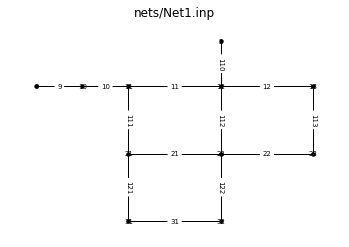

In [30]:
wdn = WDN("nets/Net1.inp", ['10', '11','12','13','21','22','23','31','32'])
wdn.show()
gen = Datagenerator(wdn)

In [19]:
X = []
y = []
for i in range(25):
  X_single, y_single = gen.gen_single_data('12', num_hours=24*5, include_time=True, noise_strength=0.3)
  X.append(X_single)
  y.append(y_single)
for i in range(15):
  X_single, y_single = gen.gen_single_data('', num_hours=24*5, include_time=True)
  X.append(X_single)
  y.append(y_single)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(*any_transform(y_train, y_test))

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0] [1, 1, 1, 0, 0, 0, 0, 0, 1, 0]


In [25]:
from sklearn.svm import SVC

# Create the model
model = ClassificationModel(SVC(gamma=0.001), medfilt_kernel_size=5)

# Learn the digits on the train subset
model.fit(X_train, y_train)

# Predict the value of the digit on the test subset
y_pred = model.predict(X_test)

Leakage at 80 Day 3 Hour 8


<Figure size 432x288 with 0 Axes>

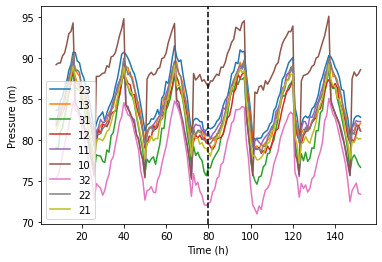

<Figure size 432x288 with 0 Axes>

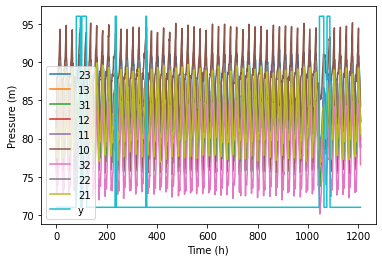

[[1079    0]
 [  58   73]]
Recall (Sns): 0.557	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Accuracy:     1.0


array([[6, 0],
       [0, 4]])

In [26]:
X_show = pd.concat(X_test)
y_show = np.concatenate(y_pred)
X_show.reset_index(drop=True, inplace=True)

y_true_show = np.concatenate(y_test)

show_data(X_show, y_show)

print_metrics(y_true_show, y_show)

print('Accuracy:    ', model.score(X_test, y_test))

preds = model.predict(X_test)

confusion_matrix(*any_transform(y_test, preds))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create the model
model = ClassificationModel(KNeighborsClassifier(), medfilt_kernel_size=5)

# Learn the digits on the train subset
model.fit(X_train, y_train)

# Predict the value of the digit on the test subset
y_pred = model.predict(X_test)

Leakage at 79 Day 3 Hour 7


<Figure size 432x288 with 0 Axes>

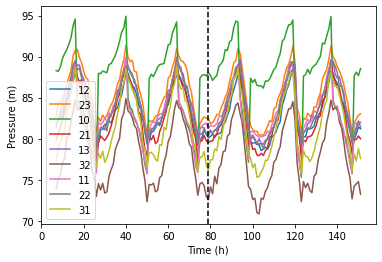

<Figure size 432x288 with 0 Axes>

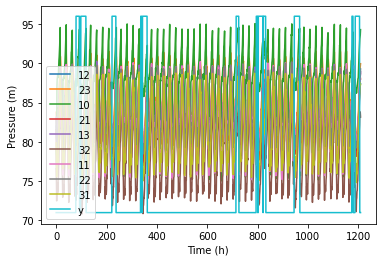

[[965   0]
 [ 80 165]]
Recall (Sns): 0.673	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Accuracy:     1.0


array([[3, 0],
       [0, 7]])

In [ ]:
X_show = pd.concat(X_test)
y_show = np.concatenate(y_pred)
X_show.reset_index(drop=True, inplace=True)

y_true_show = np.concatenate(y_test)

show_data(X_show, y_show)

print_metrics(y_true_show, y_show)

print('Accuracy:    ', model.score(X_test, y_test))

preds = model.predict(X_test)

confusion_matrix(*any_transform(y_test, preds))

In [ ]:
from sklearn.neural_network import MLPClassifier

# Create the model
model = ClassificationModel(MLPClassifier(hidden_layer_sizes=(18,20,10)), medfilt_kernel_size=5)

# Learn the digits on the train subset
model.fit(X_train, y_train)

# Predict the value of the digit on the test subset
y_pred = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Leakage at 0 Day 0 Hour 0


<Figure size 432x288 with 0 Axes>

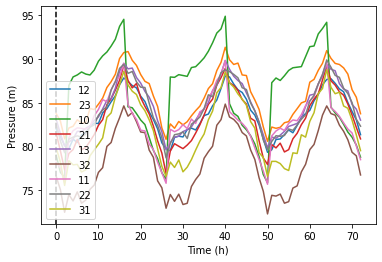

<Figure size 432x288 with 0 Axes>

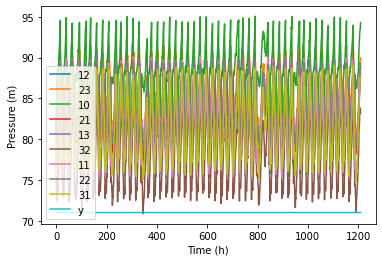

[[965   0]
 [245   0]]
Recall (Sns): 0.0	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    0.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Accuracy:     0.3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[3, 0],
       [7, 0]])

In [ ]:
X_show = pd.concat(X_test)
y_show = np.concatenate(y_pred)
X_show.reset_index(drop=True, inplace=True)

y_true_show = np.concatenate(y_test)

show_data(X_show, y_show)

print_metrics(y_true_show, y_show)

print('Accuracy:    ', model.score(X_test, y_test))

preds = model.predict(X_test)

confusion_matrix(*any_transform(y_test, preds))